In [1]:
!pip install jalali

In [90]:
import warnings
import datetime, pytz
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import jalali
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [91]:
data=pd.read_excel(r'C:\Users\asus\Desktop\PHMSA\Electricity\NEW\Time series arima.xlsx')
data.head()


,date,feeder0,week day,date.1,report time,DOFD
0,1395/01/01,11,سه شنبه,1395/01/31,22:33,27
1,1395/01/02,11,سه شنبه,1395/01/31,19:22,13
2,1395/01/03,11,سه شنبه,1395/01/31,19:21,14
3,1395/01/04,13,سه شنبه,1395/01/31,18:25,12
4,1395/01/05,9,سه شنبه,1395/01/31,18:20,60


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1095 non-null   object
 1   feeder0      1095 non-null   int64 
 2   week day     1095 non-null   object
 3   date.1       1095 non-null   object
 4   report time  1095 non-null   object
 5   DOFD         1095 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 51.5+ KB


In [93]:
data['date']=data['date'] + ' ' + data['report time']
data.head()

,date,feeder0,week day,date.1,report time,DOFD
0,1395/01/01 22:33,11,سه شنبه,1395/01/31,22:33,27
1,1395/01/02 19:22,11,سه شنبه,1395/01/31,19:22,13
2,1395/01/03 19:21,11,سه شنبه,1395/01/31,19:21,14
3,1395/01/04 18:25,13,سه شنبه,1395/01/31,18:25,12
4,1395/01/05 18:20,9,سه شنبه,1395/01/31,18:20,60


In [94]:
time=list()
for i in data['date']:
    i=i.split()
    yeardaymonth=i[0].split("/")
    hourandminute=i[1].split(":")
    time.append(JalaliDateTime(int(yeardaymonth[0]),int(yeardaymonth[1]),int(yeardaymonth[2]),int(hourandminute[0]),int(hourandminute[1])).to_gregorian())
data['date']=time

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1095 non-null   datetime64[ns]
 1   feeder0      1095 non-null   int64         
 2   week day     1095 non-null   object        
 3   date.1       1095 non-null   object        
 4   report time  1095 non-null   object        
 5   DOFD         1095 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 51.5+ KB


In [96]:
cols = ['week day', 'date.1', 'report time','DOFD']
data.drop(cols, axis=1, inplace=True)
data = data.sort_values('date')
#data.isnull().sum()

In [97]:
data = data.groupby('date')['feeder0'].sum().reset_index()

In [98]:
data = data.set_index('date')
data.index

DatetimeIndex(['2016-03-20 22:33:00', '2016-03-21 19:22:00',
               '2016-03-22 19:21:00', '2016-03-23 18:25:00',
               '2016-03-24 18:20:00', '2016-03-25 16:46:00',
               '2016-03-26 11:20:00', '2016-03-27 10:14:00',
               '2016-03-28 09:45:00', '2016-03-29 20:25:00',
               ...
               '2019-03-11 10:45:00', '2019-03-12 10:37:00',
               '2019-03-13 10:13:00', '2019-03-14 06:10:00',
               '2019-03-15 23:45:00', '2019-03-16 23:07:00',
               '2019-03-17 17:58:00', '2019-03-18 15:46:00',
               '2019-03-19 14:11:00', '2019-03-20 14:12:00'],
              dtype='datetime64[ns]', name='date', length=1095, freq=None)

In [99]:
y = data['feeder0']

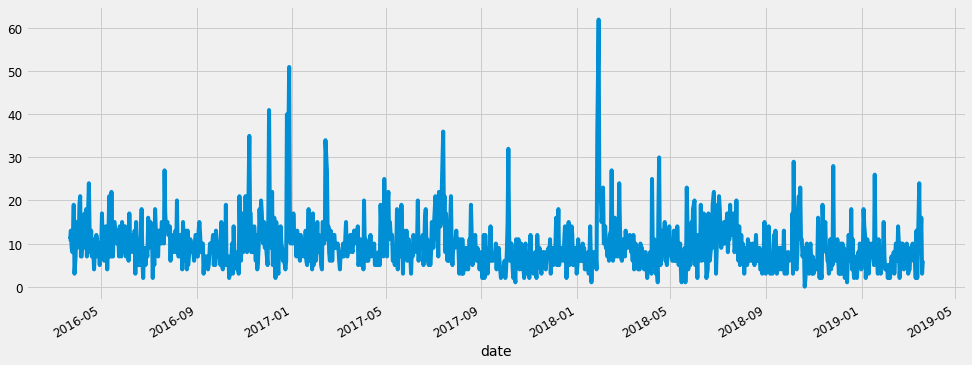

In [100]:
y.plot(figsize=(15, 6))
plt.show()

In [101]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [102]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

IndentationError: unexpected unindent (<ipython-input-102-b09dc1f80d40>, line 9)

In [103]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2511      0.023     11.002      0.000       0.206       0.296
ma.L1         -1.0000      3.188     -0.314      0.754      -7.248       5.248
ar.S.L12      -0.4849      0.015    -32.222      0.000      -0.514      -0.455
sigma2        39.3754    125.620      0.313      0.754    -206.835     285.586


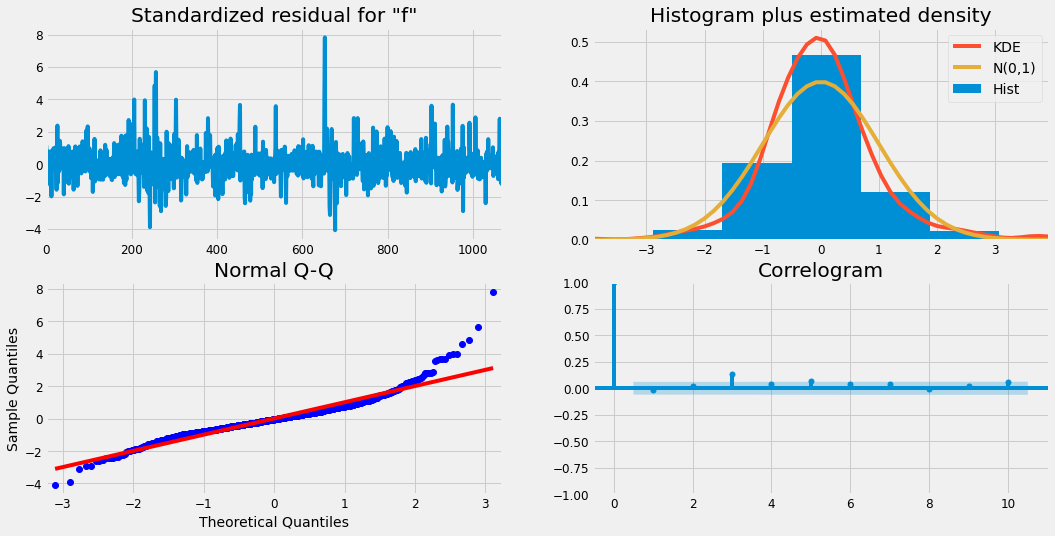

In [104]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

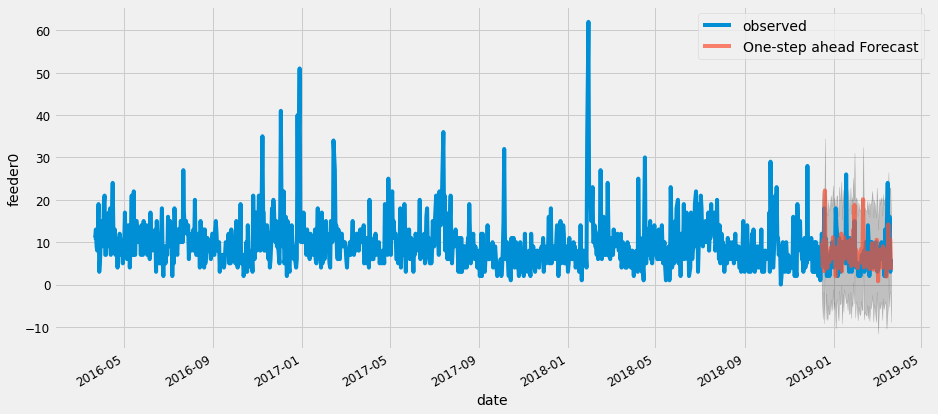

In [110]:
pred = results.get_prediction(start=pd.to_datetime('2018-12-15 10:46:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('feeder0')
plt.legend()
plt.show()

__MSE__

In [111]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 29.64


__RMSE__

In [112]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 5.44
